In [ ]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from source.datasets import get_PANDA, CustomDataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from source.vision_transformer import vit_small, vit4k_xs
from source.utils import update_state_dict
import random 
import copy 
from utils.dbscan_utils import get_core_expert,get_metrics
from utils.distance_utils import calculate_distances
from utils.patching_utils import get_patches
import json
import pandas as pd
import seaborn as sns

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
    print(device)
    
random.seed(0)
dir = '/datadisk/datasets/PANDA/'
img = ''
patch_size = 256
region_size = 4096
mini_patch_size = 16
n_classes = 5
checkpoint_256 = 'checkpoints/vit_256_small_dino_fold_4.pt'
checkpoint_4k = 'checkpoints/vit_4096_xs_dino_fold_4.pt'


expert = '2'

cuda


In [ ]:
##### DATASET #####
train_data = get_PANDA(dir,expert=expert)
train_dataset = CustomDataset(train_data)
loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=False,
    num_workers=0)


In [3]:
#### SET MODELS ####
vit_patch = vit_small(
    img_size=patch_size,
    patch_size=mini_patch_size,
    embed_dim=384,
    mask_attn=False,
    num_register_tokens=0,
)

vit_region = vit4k_xs(
    img_size=region_size,
    patch_size=patch_size,
    input_embed_dim=384,
    output_embed_dim=192,
    mask_attn=False
)

state_dict = torch.load(checkpoint_256, map_location="cpu",weights_only=False)
checkpoint_key = "teacher"
if checkpoint_key is not None and checkpoint_key in state_dict:
    state_dict = state_dict[checkpoint_key]
# remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
state_dict, msg = update_state_dict(vit_patch.state_dict(), state_dict)
vit_patch.load_state_dict(state_dict, strict=False)
for name, param in vit_patch.named_parameters():
    param.requires_grad = False
vit_patch.to(device)
vit_patch.eval()

state_dict = torch.load(checkpoint_4k, map_location="cpu",weights_only=False)
if checkpoint_key is not None and checkpoint_key in state_dict:
    state_dict = state_dict[checkpoint_key]
# remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
state_dict, msg = update_state_dict(
    vit_region.state_dict(), state_dict
)
vit_region.load_state_dict(state_dict, strict=False)
for name, param in vit_region.named_parameters():
    param.requires_grad = False
vit_region.to(device)
vit_region.eval()

VisionTransformer4K(
  (phi): Sequential(
    (0): Linear(in_features=384, out_features=192, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((192,), eps

In [ ]:
#### GET FEATURES ####
features = []
labels = []
for _,img,label in loader:
        img = img.to(device)
        label = label.to(device)
        feat,label = get_patches(img,vit_patch,vit_region,patch_size,region_size,y=label,mode='both',region=True)
        features.extend(feat.cpu().detach().numpy())
        labels.append(label.cpu().detach().numpy())



features_aux = []
labels_aux = []
idx_aux = []
for i,lbl in enumerate(labels):
    feat = features[i]
    for j,label in enumerate(lbl):
            features_aux.append(feat[j])
            idx_aux.append(f'{i}_{j}')
            labels_aux.append(np.unique(label))

#### PCA ####
pca = PCA(n_components=0.9)
principalComponents = pca.fit_transform(features_aux)
explained_variance = pca.explained_variance_ratio_
total_variance = sum(list(explained_variance))*100


knn_features = []
knn_labels = []
knn_idx = []
for i,lbl in enumerate(labels_aux):
    if (2 in lbl and 3 in lbl) or (2 in lbl and 5 in lbl) or (3 in lbl and 4 in lbl) or (3 in lbl and 5 in lbl) or (4 in lbl and 5 in lbl):
        pass
    else:
        knn_features.append(principalComponents[i])
        knn_idx.append(idx_aux[i])
        if len(lbl)==1:
            knn_labels.append(lbl[0])
        else:
            knn_labels.append(lbl[-1])


###### DIVIDE BY CLASSES #####
cl_0 = {}
cl_1 = {}
cl_2 = {}
cl_3 = {}
cl_4 = {}
cl_5 = {}
for i, idx in enumerate(knn_idx):
    div_index = idx.split('_')
    expert_ann = labels[int(div_index[0])][int(div_index[1])]
    cl,count = np.unique(expert_ann,return_counts=True)
    cl_counts = dict(zip(cl,count))
    if len(cl)==1 and cl[0]==0:
        cl_0[idx] = knn_features[i]
    elif knn_labels[i] == 1 :
        if cl_counts[1]/(256**2)>0.15 and 0 not in cl:
            cl_1[idx] = knn_features[i]
    elif knn_labels[i] == 2:
        if cl_counts[2]/(256**2)>0.15 and 0 not in cl:
            cl_2[idx] = knn_features[i]
    elif knn_labels[i] == 3:
        if cl_counts[3]/(256**2)>0.15 and 0 not in cl:
            cl_3[idx] = knn_features[i] 
    elif knn_labels[i] == 4:
        if cl_counts[4]/(256**2)>0.15 and 0 not in cl:
            cl_4[idx] = knn_features[i] 
    elif knn_labels[i] == 5:
        if cl_counts[5]/(256**2)>0.15 and 0 not in cl:
            cl_5[idx] = knn_features[i] 
        

In [6]:
###### DISTANCES #######
dist1 = calculate_distances(cl_1)
dist2 = calculate_distances(cl_2)
dist3 = calculate_distances(cl_3)
dist4 = calculate_distances(cl_4)
dist5 = calculate_distances(cl_5)

In [ ]:
mins = [45,50,55,60,65]
maxs = [80,85,90,95]

variability = {}
for min in mins:
    for max in maxs:
        centroids_orig,labels_orig,eps_orig,min_samples_orig = get_core_expert([cl_1,cl_2,cl_3,cl_4,cl_5],[dist1,dist2,dist3,dist4,dist5],min,max)
        sc_orig,sc2_orig,eucl_distances_orig,min_dist_orig,outliers_orig,dists_orig,means_orig,stds_orig,_ = get_metrics(centroids_orig,labels_orig,return_neighbors=False)
        variability[f'min{min}_max{max}'] = {'min_samples':min_samples_orig,'sc':sc_orig}

In [ ]:
def convert_np(obj):
    if isinstance(obj, dict):
        return {k: convert_np(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_np(v) for v in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

variability_py = convert_np(variability)

with open(f'variability_{expert}.json', 'w') as f:
    json.dump(variability_py, f)

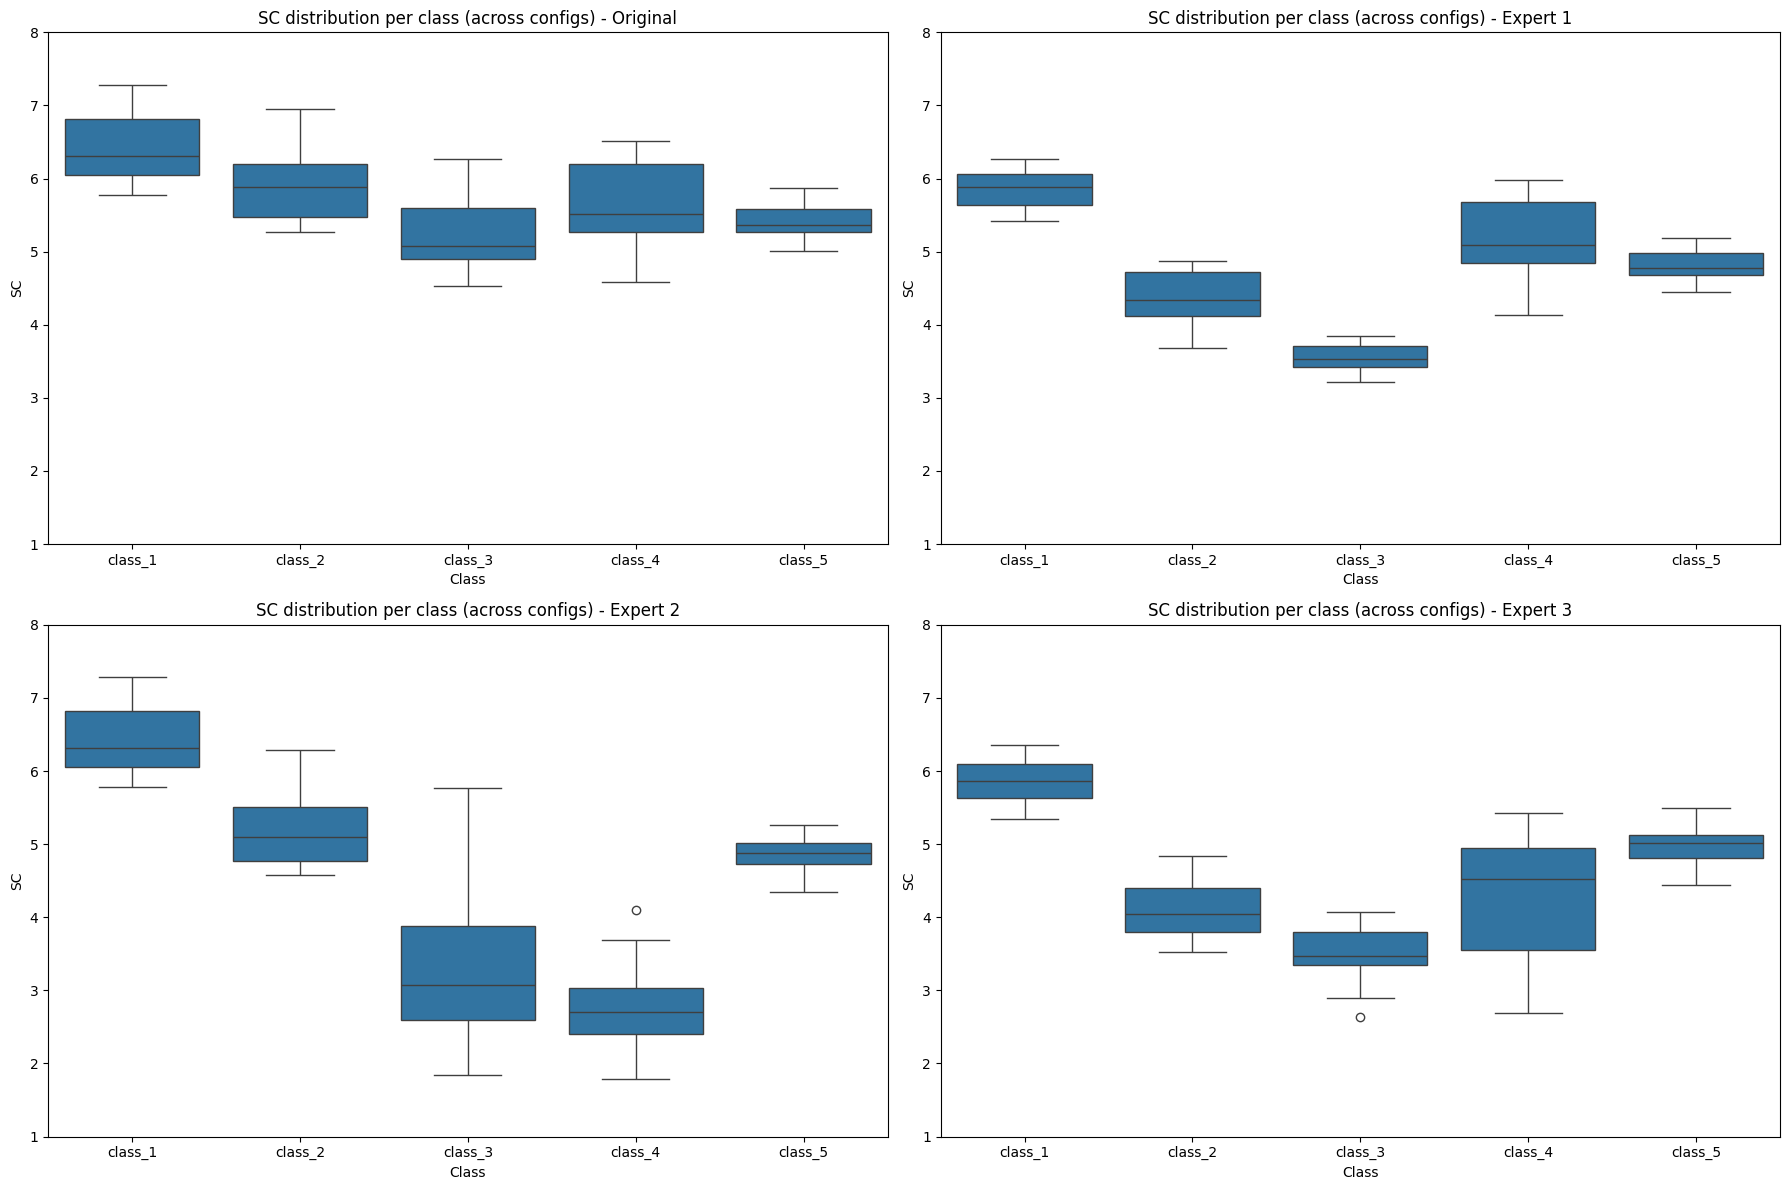

In [ ]:
variability_orig = json.load(open('variability.json','r'))
variability_1 = json.load(open('variability_1.json','r'))
variability_2 = json.load(open('variability_2.json','r'))
variability_3 = json.load(open('variability_3.json','r'))

def plot_sc(variability):
    records = []
    for config, vals in variability.items():
        for cls_idx, (sc) in enumerate(vals["sc"], start=1):
            records.append({
                "class": f"class_{cls_idx}",
                "sc": sc
            })

    df = pd.DataFrame(records)
    return df

df_orig = plot_sc(variability_orig)
df_1 = plot_sc(variability_1)
df_2 = plot_sc(variability_2)
df_3 = plot_sc(variability_3)
# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. SC per class (aggregated across configs)
sns.boxplot(data=df_orig, x="class", y="sc", ax=axes[0, 0])
axes[0, 0].set_title("SC distribution per class (across configs) - Original")
axes[0, 0].set_xlabel("Class")
axes[0, 0].set_ylabel("SC")
axes[0, 0].set_ylim(1, 8)



# 2. min_samples per class (aggregated across configs)
sns.boxplot(data=df_1, x="class", y="sc", ax=axes[0, 1])
axes[0, 1].set_title("SC distribution per class (across configs) - Expert 1")
axes[0, 1].set_xlabel("Class")
axes[0, 1].set_ylabel("SC")
axes[0, 1].set_ylim(1, 8)


# 3. SC per config (aggregated across classes)
sns.boxplot(data=df_2, x="class", y="sc", ax=axes[1, 0])
axes[1, 0].set_title("SC distribution per class (across configs) - Expert 2")
axes[1, 0].set_xlabel("Class")
axes[1, 0].set_ylabel("SC")
axes[1, 0].set_ylim(1, 8)


# 4. min_samples per config (aggregated across classes)
sns.boxplot(data=df_3, x="class", y="sc", ax=axes[1, 1])
axes[1, 1].set_title("SC distribution per class (across configs) - Expert 3")
axes[1, 1].set_xlabel("Class")
axes[1, 1].set_ylabel("SC")
axes[1, 1].set_ylim(1, 8)

plt.tight_layout()
plt.show()


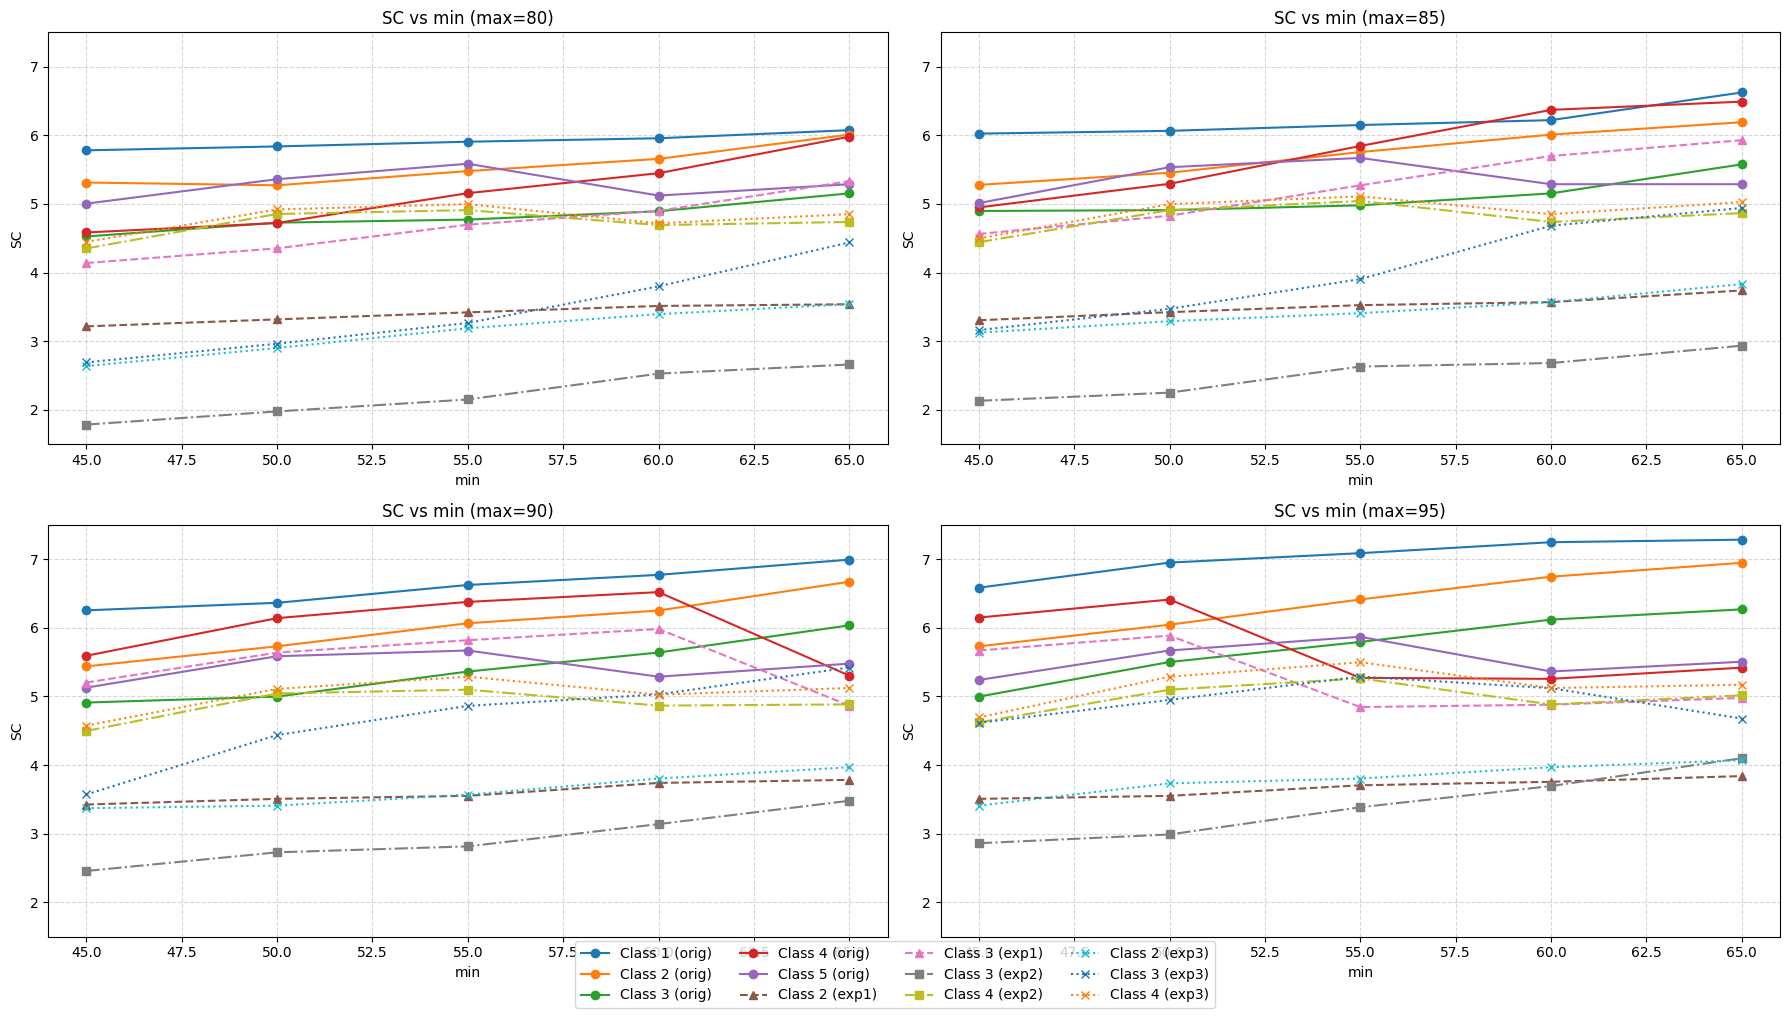

In [ ]:
plt.figure(figsize=(18, 10))

# Store handles and labels for legend
handles_labels = []

for idx, max_val in enumerate(maxs):
    plt.subplot(2, 2, idx+1)
    # Plot original classes (expert 0)
    for class_idx in range(n_classes):
        sc_values = []
        for min_val in mins:
            key = f'min{min_val}_max{max_val}'
            sc = variability_orig[key]['sc'][class_idx]
            sc_values.append(sc)
        line, = plt.plot(mins, sc_values, marker='o', label=f'Class {class_idx+1} (orig)')
        if idx == 0:
            handles_labels.append((line, f'Class {class_idx+1} (orig)'))
    # Plot classes 2,3,4 for expert 1
    for class_idx in [2, 3]:
        sc_values = []
        for min_val in mins:
            key = f'min{min_val}_max{max_val}'
            sc = variability_1[key]['sc'][class_idx]
            sc_values.append(sc)
        line, = plt.plot(mins, sc_values, marker='^', linestyle='--', label=f'Class {class_idx} (exp1)')
        if idx == 0:
            handles_labels.append((line, f'Class {class_idx} (exp1)'))
    # Plot classes 2,3,4 for expert 2
    for class_idx in [3, 4]:
        sc_values = []
        for min_val in mins:
            key = f'min{min_val}_max{max_val}'
            sc = variability_2[key]['sc'][class_idx]
            sc_values.append(sc)
        line, = plt.plot(mins, sc_values, marker='s', linestyle='-.', label=f'Class {class_idx} (exp2)')
        if idx == 0:
            handles_labels.append((line, f'Class {class_idx} (exp2)'))
    # Plot classes 2,3,4 for expert 3
    for class_idx in [2, 3, 4]:
        sc_values = []
        for min_val in mins:
            key = f'min{min_val}_max{max_val}'
            sc = variability_3[key]['sc'][class_idx]
            sc_values.append(sc)
        line, = plt.plot(mins, sc_values, marker='x', linestyle=':', label=f'Class {class_idx} (exp3)')
        if idx == 0:
            handles_labels.append((line, f'Class {class_idx} (exp3)'))
    plt.title(f'SC vs min (max={max_val})')
    plt.xlabel('min')
    plt.ylabel('SC')
    plt.ylim(1.5,7.5)
    plt.grid(True, linestyle='--', alpha=0.5)

# Add a common legend below all subplots
handles, labels = zip(*handles_labels)
plt.figlegend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.show()